In [2]:
#!pip install powerlaw
import pandas as pd
import glob
import numpy as np
import pickle
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from collections import Counter
import powerlaw
import math
import operator

In [163]:
!pip install --upgrade networkx

  Attempting uninstall: networkx
    Found existing installation: networkx 2.5
    Uninstalling networkx-2.5:
      Successfully uninstalled networkx-2.5


In [166]:
import networkx as nx

In [15]:
with open(r"cleaned_data\unique_users", 'rb') as file:
    unique_users = pickle.load(file)

with open(r"cleaned_data\user_net_submissions", 'rb') as file:
    submissions = pickle.load(file)

with open(r"cleaned_data\user_net_comments", 'rb') as file:
    comments = pickle.load(file)

In [122]:
#Graph creation

G = nx.MultiDiGraph()
G.add_nodes_from(set(unique_users))
print(len(G.nodes))

152730


In [17]:
print(comments)
print(submissions)

           index       id           author link_id parent_id
25            34  c02s9t4  LiberalDemocrat   648os     648os
55            72  c02s9u6        DiscoWolf   648os     648os
63            83  c02s9uh         Flemlord   648p5     648p5
69            89  c02s9un  LiberalDemocrat   648oy     648oy
72            94  c02s9us  LiberalDemocrat   648p5     648p5
...          ...      ...              ...     ...       ...
4873684  7242866  c064gsy     rhythmicidea   7amdg   c064gqo
4873685  7242867  c064gsz   blackwhitegrey   7ajij     7ajij
4873686  7242868  c064gt0       Drewster58   7amg7     7amg7
4873687  7242869  c064gt1           eerock   7akoc     7akoc
4873688  7242870  c064gt2           mycall   7ajjm     7ajjm

[3781518 rows x 5 columns]
            id         author
0        648oo          DITUS
1        648op         rmuser
3        648or          zorno
4        648os         rmuser
6        648ou  anteeknetshop
...        ...            ...
2519831  7amfx      oddietaco


In [18]:
#Sort data

comments = comments.sort_values(by='link_id', ascending=False)
print(comments)
submissions = submissions.sort_values(by='id', ascending = False)
print(submissions)

           index       id      author link_id parent_id
1386311  2052819     7v8c  julenissen   7mq30     7mq30
1386252  2052738     7v61  catlebrity   7mq2q     7mq2q
1386322  2052839     7v8w       stumo   7mq1x     7mq1x
1386337  2052865     7v9m       eMigo   7mq1x     7mq1x
1386256  2052742     7v65  russianout   7mq1r     7mq1r
...          ...      ...         ...     ...       ...
139          170  c02s9ww   reflibman   648or     648or
2685        3784  c02scpa   sexydarin   648op     648op
2543        3608  c02scke     quiller   648op     648op
579          766  c02sadg     fotoman   648op     648op
6055        8511  c02sgcn   Gargilius   648op     648op

[3781518 rows x 5 columns]
           id         author
846563  7mq3v         klippa
846559  7mq3r       middkidd
846558  7mq3q       bixiebix
846551  7mq3j   ohstrangeone
846550  7mq3h      shadowvox
...       ...            ...
6       648ou  anteeknetshop
4       648os         rmuser
3       648or          zorno
1       64

In [23]:
#Divide data

mask = comments['link_id'] == comments['parent_id']
comments_on_submissions = comments[mask]
comments_on_comments_mask = ~mask
comments_on_comments = comments[comments_on_comments_mask]

print(comments_on_submissions)
print(comments_on_comments)

           index       id      author link_id parent_id
1386311  2052819     7v8c  julenissen   7mq30     7mq30
1386252  2052738     7v61  catlebrity   7mq2q     7mq2q
1386322  2052839     7v8w       stumo   7mq1x     7mq1x
1386337  2052865     7v9m       eMigo   7mq1x     7mq1x
1386256  2052742     7v65  russianout   7mq1r     7mq1r
...          ...      ...         ...     ...       ...
139          170  c02s9ww   reflibman   648or     648or
2685        3784  c02scpa   sexydarin   648op     648op
2543        3608  c02scke     quiller   648op     648op
579          766  c02sadg     fotoman   648op     648op
6055        8511  c02sgcn   Gargilius   648op     648op

[1475742 rows x 5 columns]
           index       id           author link_id parent_id
1386248  2052730     7v5t   LapsedPacifist   7mq1o      7v47
1386225  2052690     7v4p         The_Yeti   7mpwf      7ujp
1385832  2052096     7uo3      SnowLeopard   7mpwf      7ug0
1386019  2052395     7uwg      SnowLeopard   7mpwf      

In [123]:
def generate_edge(x,y):
    if x != y:
        if (x, y, x) in G.edges:  
            old_weight = G.get_edge_data(x, y, key=x)['weight']
            new_weight = old_weight + 1
            G.add_edge(x, y, key = x, weight=new_weight)
        else:
            G.add_edge(x, y, key = x, weight=1)

In [30]:
submissions = submissions.reset_index()
print(submissions)

         index     id         author
0       846563  7mq3v         klippa
1       846559  7mq3r       middkidd
2       846558  7mq3q       bixiebix
3       846551  7mq3j   ohstrangeone
4       846550  7mq3h      shadowvox
...        ...    ...            ...
797902       6  648ou  anteeknetshop
797903       4  648os         rmuser
797904       3  648or          zorno
797905       1  648op         rmuser
797906       0  648oo          DITUS

[797907 rows x 3 columns]


In [124]:
#Add edges from comments_on_submissions

comments_on_submissions.reset_index()
curr_submissions_index = 0
cur_submissions_id = submissions.iat[curr_submissions_index, submissions.columns.get_loc('id')]
for _,_,_,author,link_id,_ in comments_on_submissions.itertuples():
    while link_id != cur_submissions_id:
            curr_submissions_index+=1
            cur_submissions_id = submissions.iat[curr_submissions_index, submissions.columns.get_loc('id')]
    curr_submissions_author = submissions.iat[curr_submissions_index, submissions.columns.get_loc('author')]
    generate_edge(author,curr_submissions_author)

In [117]:
#Create dictionary with key,value pairs (comment_id, author)

dict2 = dict(zip(comments_on_comments['id'], comments_on_comments['author']))

In [126]:
#Add edges from comments_on_comments

comments_on_comments.reset_index()
for _,_,_,author,link_id, parent_id in comments_on_comments.itertuples():
    if parent_id in dict2: 
        comment_author = dict2[parent_id]
        generate_edge(author, comment_author)

In [130]:
#Save UserNet

nx.info(G)

output_path = "models/UserNet.gml"
nx.write_gml(G, output_path)

In [148]:
G = nx.read_gml(output_path)

In [149]:
nodesToRemove = list(nx.isolates(G))
G.remove_nodes_from(nodesToRemove)
print(len(list(G.nodes)))
output_path = "models/UserNetFiltered.gml"
nx.write_gml(G, output_path)

76038


In [150]:
#Network density

number_of_edges = G.number_of_edges()
number_of_nodes = G.number_of_nodes()

absolut_number_of_edges = number_of_nodes * (number_of_nodes - 1)
print(absolut_number_of_edges)
network_density = number_of_edges/absolut_number_of_edges

print("Gustina mreze je = ",network_density)

5781701406
Gustina mreze je =  0.0003412358856776285


In [196]:
print(G.number_of_edges())

1972924


In [152]:
[len(c) for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True)]

[36746,
 10,
 6,
 5,
 5,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,

In [154]:
#Find strongly connected components

S = [G.subgraph(c).copy() for c in sorted(nx.strongly_connected_components(G), key=len, reverse=True)]
largest_component = S[0]
print("Number of components : ", len(S))
print("Number of nodes in largest component : ", largest_component.number_of_nodes())

Number of components :  39211
Number of nodes in largest component :  36746


In [153]:
#Find weakly connected components

S = [G.subgraph(c).copy() for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)]
largest_weakly_connected_component = S[0]
print("Number of components : ", len(S))
print("Number of nodes in largest component : ", largest_component.number_of_nodes())

Number of components :  639
Number of nodes in largest component :  74469


In [193]:
#Save the largest component

output_path = "models/UserNetLargestComponent.gml"
nx.write_gml(largest_component, output_path)

In [5]:
G = nx.read_gml("models/UserNetLargestComponent.gml")

In [191]:
#3.8 Diameter and Average shortest path
#Ne moze
import networkx as nx
from networkx.algorithms import approximation
import networkx as nx

diameter_value = approximation.diameter(largest_component)
print("SNetT diameter: ", diameter_value)

AttributeError: module 'networkx.algorithms.approximation' has no attribute 'diameter'

In [192]:
average_shortest_path_length = nx.average_shortest_path_length(largest_component, weight='weight') 
print("Average shortest path length with weight: ", average_shortest_path_length)
average_shortest_path_length = nx.average_shortest_path_length(largest_component) 
print("Average shortest path length without weight: ", average_shortest_path_length)
# NetworkXError: Graph is not weakly connected.

KeyboardInterrupt: 

In [194]:
average_clustering_coefficient = nx.average_clustering(G)
global_clustering_coefficient = nx.transitivity(G)

NetworkXNotImplemented: not implemented for multigraph type

In [195]:
G2 = nx.DiGraph(G)
eigen_centrality = nx.average_clustering(G2)

In [ ]:
#Diameter: 10
#Radius: 5
#Average Path length: 3.20275654675197

In [6]:
#3.12
# asortativnost na osnovu netežinskog stepena čvora -> NE MOZE zbog konfiguracije mreze, svi imaju isti stepen
r1 = nx.degree_assortativity_coefficient(G)
#print("Koeficijent asortativnosti na osnovu netežinskog stepena čvora: ", r1)

In [7]:
print(r1)

-0.04617843740220365


In [10]:
#3.14 Degree distribution
#TODO

def plot_deg_frequency(G, weighted = False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
        
    _, deg_list = zip(*degrees)
    deg_counts = Counter(deg_list)        
    #print(deg_counts)
    x, y = zip(*deg_counts.items())                                                      

    plt.figure(1)   

    # prep axes   
    if weighted:
        plt.xlabel('weighted degree')  
    else:
        plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(x))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(0, max(y))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(x, y, marker='.')                                                                                                    
    plt.show()

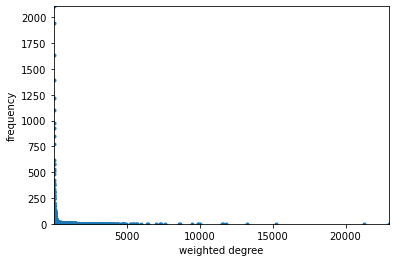

In [11]:
plot_deg_frequency(G, weighted = True)

[8910, 7783, 6740, 5568, 5515, 5466, 4670, 4657, 4475, 4007, 3988, 3904, 3812, 3761, 3740, 3604, 3588, 3524, 3468, 3436, 3422, 3330, 3320, 3263, 3260, 3175, 3102, 3098, 3041, 3025, 3001, 2935, 2908, 2835, 2755, 2740, 2690, 2681, 2662, 2662, 2655, 2653, 2653, 2649, 2640, 2625, 2619, 2612, 2607, 2607, 2594, 2574, 2562, 2550, 2528, 2527, 2515, 2503, 2493, 2481, 2477, 2469, 2462, 2462, 2423, 2415, 2395, 2391, 2360, 2329, 2299, 2299, 2281, 2263, 2263, 2258, 2238, 2224, 2210, 2205, 2200, 2192, 2188, 2183, 2174, 2171, 2159, 2129, 2119, 2103, 2087, 2082, 2077, 2075, 2072, 2064, 2057, 2053, 2044, 2037, 2034, 2032, 2021, 2011, 2003, 2002, 2002, 1992, 1990, 1976, 1975, 1952, 1945, 1942, 1929, 1924, 1922, 1918, 1914, 1909, 1907, 1906, 1905, 1901, 1884, 1875, 1874, 1870, 1866, 1862, 1850, 1848, 1845, 1844, 1831, 1827, 1819, 1806, 1802, 1800, 1799, 1799, 1793, 1791, 1789, 1788, 1786, 1781, 1779, 1779, 1774, 1768, 1761, 1758, 1756, 1755, 1753, 1751, 1750, 1743, 1739, 1729, 1724, 1713, 1709, 1702, 170

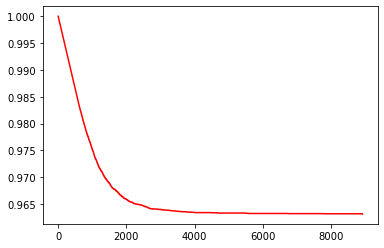

In [12]:
# Power law distribution

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
print(degree_sequence)
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

max_deg = max(deg) # hoćemo po jedan bin za svaki stepen čvora

# izračunavanje histograma
values, base = np.histogram(deg, bins = max_deg)

# kumulativna suma (inkluzivna prefiksna suma)
cumulative = np.cumsum(values)

# plotovanje komplementarne kumulativne raspodele stepena čvora P(X>x)
plt.plot(base[:-1], [float(x)/len(G) for x in len(G) - cumulative], c='red')

plt.show()

In [13]:
results = powerlaw.Fit(degree_sequence)
print(results.supported_distributions)

print(results.power_law.alpha)
print(results.power_law.xmin)
print(results.power_law.sigma)
R, p = results.distribution_compare('power_law', 'lognormal')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")
R, p = results.distribution_compare('power_law', 'exponential')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")
R, p = results.distribution_compare('power_law', 'truncated_power_law')
print(f"Loglikelihood ratio: {R}")
print(f"Statistical significance: {p}")

# eksponencijalna

Calculating best minimal value for power law fit
{'power_law': <class 'powerlaw.Power_Law'>, 'lognormal': <class 'powerlaw.Lognormal'>, 'exponential': <class 'powerlaw.Exponential'>, 'truncated_power_law': <class 'powerlaw.Truncated_Power_Law'>, 'stretched_exponential': <class 'powerlaw.Stretched_Exponential'>, 'lognormal_positive': <class 'powerlaw.Lognormal_Positive'>}
3.357462027654507
952.0
0.0967278386370514
Loglikelihood ratio: -5.712881026750495
Statistical significance: 0.05685111617221731
Loglikelihood ratio: 11.465023677211054
Statistical significance: 0.2800587338612248


Assuming nested distributions


Loglikelihood ratio: -5.670994538105182
Statistical significance: 0.0007577412134861516


In [14]:
#3.15 Habovi i autoriteti

hubs, authorities =nx.hits(G)

hub_items = sorted(hubs.items(), key=operator.itemgetter(1), reverse=True)[:10]
print("SNetF Hubs\n")
for hub_item in hub_items:
    print(hub_item)

authority_items = sorted(authorities.items(), key=operator.itemgetter(1), reverse=True)[:10]
print("\nSNetF Authorities\n")
for authority_item in authority_items:
    print(authority_item)

SNetF Hubs

('malcontent', 0.0031086961824934997)
('NoMoreNicksLeft', 0.0030286784011830034)
('matts2', 0.002825724475116414)
('cartooncorpse', 0.0022816071295664125)
('randomb0y', 0.0020466802453137757)
('eleitl', 0.0020235375315977595)
('alllie', 0.0019269023821792506)
('RugerRedhawk', 0.001812345666351941)
('sakebomb69', 0.001800023338738594)
('mutatron', 0.0017505951369599516)

SNetF Authorities

('qgyh2', 0.010139825986875883)
('rmuser', 0.00990534361316391)
('alllie', 0.005872691355346865)
('maxwellhill', 0.004809302066666243)
('noname99', 0.004771453664315664)
('georgewashingtonblog', 0.004618163353814055)
('twolf1', 0.004599607910239071)
('IAmperfectlyCalm', 0.004216141682750718)
('gst', 0.004046468235431592)
('matts2', 0.003929323138609022)


In [15]:
#3.16 
#degree_centrality, closeness_centrality ==1 i ista za SVE
#betweenes_centrality  -> ukljucuje se i weight opcija

print("Top 10 Degree centrality:\n")
DC = nx.degree_centrality(G)
dc_items = sorted(DC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for dc_item in dc_items:
    print(dc_item[0], "\t\t",dc_item[1], "\t",G.degree[dc_item[0]])
    
print("\nTop 10 Closeness centrality:\n")
CC = nx.closeness_centrality(G)
cc_items = sorted(CC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for cc_item in cc_items:
    node = cc_item[0]
    print(cc_item[0], "   ", cc_item[1])

print("\nTop 10 Betweenness centrality:\n")
BC = nx.betweenness_centrality(G)
bc_items = sorted(BC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for bc_item in bc_items:
    node = bc_item[0];
    print(bc_item[0], "   ", bc_item[1])
    
print("\nTop 10 Betweenness centrality with weight:\n")
BC = nx.betweenness_centrality(G, weight='weight')
bc_items = sorted(BC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for bc_item in bc_items:
    node = bc_item[0];
    print(bc_item[0], "   ", bc_item[1])

Top 10 Degree centrality:

rmuser 		 0.24248197033610014 	 8910
qgyh2 		 0.21181113076609062 	 7783
alllie 		 0.18342631650564703 	 6740
noname99 		 0.1515308205197986 	 5568
swampsparrow 		 0.15008844740781058 	 5515
7oby 		 0.14875493264389714 	 5466
gst 		 0.1270921213770581 	 4670
NoMoreNicksLeft 		 0.12673833174581575 	 4657
maxwellhill 		 0.12178527690842292 	 4475
twolf1 		 0.10904885018369846 	 4007

Top 10 Closeness centrality:



KeyboardInterrupt: 

In [16]:
#1.17 Eigenvector centrality
#Napomena naci zasto su ovakvi rezultati

print("\nTop 10 Eigenvector centrality:\n")
EC = nx.eigenvector_centrality(G)
ec_items = sorted(EC.items(), key=operator.itemgetter(1), reverse=True)[:10]
for ec_item in ec_items:
    print(ec_item[0], "   ", ec_item[1])


Top 10 Eigenvector centrality:



NetworkXNotImplemented: not implemented for multigraph type